In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import get_cmap
import seaborn as sns
import string
import pickle # save data frame (results) in a .pkl file
import pandas as pd
from datetime import datetime
import os, sys
import re
import grakel as gk


sys.path.insert(0, 'C:/Users/ragna/Documents/Ragnar/Code/MMDGraph')
#from importlib import reload
from mmdutils import readfoldertopanda, PlotROCGeneral, plotVaryingBGDEG, findAUC
#reload(readfoldertopanda)
import importlib
importlib.reload(sys.modules['mmdutils'])
from mmdutils import readfoldertopanda, PlotROCGeneral, plotVaryingBGDEG, findAUC
from myKernels import hashkernel, WWL, DeepKernel, GraphInvariant
import MMDforGraphs as mg

In [2]:
def issymmetric(a, rtol=1e-05, atol=1e-08):
    """
    Check if matrix is symmetric
    """
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

In [3]:
from importlib import reload  
foo = reload(mg)

n_1 = 60
n_2 = 60
nnode_1 = 15
nnode_2 = 20
loc_latent_1 = 0
loc_latent_2 = 0.3

X1 = mg.CliqueGraph(n_1, nnode_1,  l = 'samelabels_float', a = 'normal_conditional_on_latent_mean_rv', loc_latent = loc_latent_1)
X1.Generate()

X2 = mg.CliqueGraph(n_2, nnode_2,  l = 'samelabels_float', a = 'normal_conditional_on_latent_mean_rv', loc_latent = loc_latent_2)
X2.Generate()

Gs = X1.Gs + X2.Gs

In [5]:
# Works
# kernel = hashkernel.HashKernel(base_kernel = 'WL_kernel', param = {'iterations':20,
#                                                                     'lsh_bin_width':0.1, 
#                                                                     'sigma':1,
#                                                                     'normalize':True,
#                                                                     'scale_attributes':True,
#                                                                     'attr_name': 'attr',
#                                                                     'label_name':'label',
#                                                                     'wl_iterations':0,
#                                                                     'normalize':True})
# K = kernel.fit_transform(Gs)

# works but slow#
# kernel = GraphInvariant.GIK(local = True, label_name = 'label', attr_name= 'attr', params = {'wl_itr':4,'distances':3,  'c':0.1,'normalize':False })
# K = kernel.fit_transform(Gs)

# prop
# kernel = [{"name": "propagation", "t_max": 4, "w":0.05, 'with_attributes':True, "M":"L2"}]
# init_kernel = gk.GraphKernel(kernel= kernel, normalize=False)
# graph_list = gk.graph_from_networkx(Gs, node_labels_tag= 'attr')
# K = init_kernel.fit_transform(graph_list)

# works
kernel = [{"name": "GH", 'kernel_type':('gaussian', 0)}]
init_kernel = gk.GraphKernel(kernel= kernel, normalize=False)
graph_list = gk.graph_from_networkx(Gs, node_labels_tag= 'attr')
K = init_kernel.fit_transform(graph_list)


# kernel = [{"name": "SP", 'as_attributes':True}]
# init_kernel = gk.GraphKernel(kernel= kernel, normalize=False)
# graph_list = gk.graph_from_networkx(Gs, node_labels_tag= 'attr')
# K = init_kernel.fit_transform(graph_list)


print(issymmetric(K))


MMD_functions = [mg.MMD_b, mg.MMD_u]

# initialize bootstrap class, we only want this to be initalized once so that numba njit
# only gets compiled once (at first call)
kernel_hypothesis = mg.BoostrapMethods(MMD_functions)
function_arguments=[dict(n = X1.n, m = X2.n ), dict(n = X1.n, m = X2.n )]
kernel_hypothesis.Bootstrap(K, function_arguments, B = 100)
print(kernel_hypothesis.p_values)

True
{'MMD_b': 0.0, 'MMD_u': 0.0}


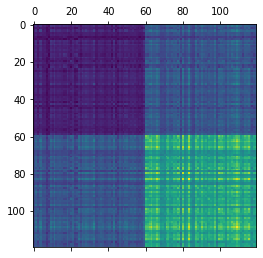

In [11]:
plt.matshow(K)